ROB 101: Computational Linear Algebra | University of Michigan, Department of Robotics



Please read carefully. Ask questions if you are unsure.
-------------------------------------------------------



**We use an auto-grader to check your work. If you invent new notation (such as, new variable names) for yourself, you will mess up the auto-grader and receive no points. We will NOT do manual regrades because of failure to use the requested variable names.**



**Do not reinitialize variables and data provided for you. Please just run the cells when information is initialized for you. DO NOT RETYPE IT unless it is in a static cell (a cell that has no run button).**



**Check your answers before submission and read the Canvas assignment instructions.**



In [1]:
using LinearAlgebra, Plots, Random
gr()

Plots.GRBackend()



---



In [2]:
function forwardsub(L, b)    
    (nr,nc) = size(L)
    x = Vector{Float64}(undef,nc)
    if minimum(abs.(diag(L))) < 1e-8
        println("L is close to singular. I will not solve this problem")
        return x
    else    
        x[1] = b[1] / L[1,1]
        for i = 2:nc
            x[i]=( b[i] - L[i,1:i-1]' * x[1:i-1] ) / L[i,i]
        end
        return x  
    end
end

#= 
The QR pipeline for minimum norm solution of Ax=b when
the ROWS of A are linearly independent 
(yes, the columns of A' are linearly independent)
=#

function minNormUnderdetermined(A,b)
    F = qr(A')
    Q = Matrix(F.Q)
    R = Matrix(F.R)
    beta = forwardsub(R', b) 
    xStar =Q*beta
    return xStar
end

minNormUnderdetermined (generic function with 1 method)

Below are functions that we are providing so that you can perform a computer simulation of a cart and a Segway. It is worth looking through the functions. Our mathematical models of the cart and Segway will be expressed in the form:



x\_{k+1} = A x\_k + B u\_k



Because you have dealt with iterative methods for solving equations (root finding, optimization), we hope that you will find a mathematical model in the form of an iteration rather natural!



In [3]:
#= 
Functions for simulating discrete-time versions of ODEs. 
These will be used for a cart 
=#

function simModelNomOpenLoop(A,B,x0,u)
    # given x0 and a control sequence u
    # compute the resulting trajectory
    # for k = 0:length(u)
    # using a perfect model 
    # Assume u is a vector and not a 2d array
    (rA,cA) = size(A)
    xTraj = Array{Float64,2}(undef,rA,0)
    N = length(u)
    xTraj=[xTraj x0]
    for k = 1:N
        xk = xTraj[:,k]
        uk = u[k]
        xkp1 = A*xk+B*uk
        xTraj = [xTraj xkp1]          
    end
    return xTraj
end

function simModelDisturbedOpenLoop(A,B,x0,u)
    # given x0 and a control sequence u
    # compute the resulting trajectory
    # for k = 0:length(u)
    # when the model has unexpected deviations 
    # from its nominal behavior!
    # Assume u is a vector and not a 2d array
    dt=0.1
    (rA,cA) = size(A)
    xTraj = Array{Float64,2}(undef,rA,0)
    N = length(u)
    xTraj=[xTraj x0]
    for k = 1:N
        xk = xTraj[:,k]
        uk = u[k]
        xkp1 = xkPlus1Disturbed(A,B,xk,uk,dt)
        xTraj = [xTraj xkp1]          
    end
    return xTraj
end

function xkPlus1DisturbedCart(A,B,xk,uk,dt)
    # Introduce disturbances that make perfect predictions 
    # not work in engineering practice
    (rA,cA) = size(A)
    Anom=A
    d=0.1
    Amud=A+dt*[0 0;0 -d]
    Awind=A+dt*[0 0;0 2*d]
    xkp1 = Array{Float64,2}(undef,rA,1)
    for k = 1:N
        if  abs(xk[1]-3)<1
            xkp1 = Amud*xk+B*uk            
        elseif abs(xk[1]-11)<0.6
            xkp1 = Awind*xk+B*uk
        else
            xkp1 = Anom*xk+B*uk
        end    
    end
    return xkp1
end

function xkPlus1DisturbedSegway(A,B,xk,uk,dt)
    # Introduce disturbances that make perfect predictions 
    # not work in engineering practice
    (rA,cA) = size(A)
    d=0.1
    Anom=A
    Dmud=zeros(rA,cA); Dmud[rA,rA]=-d
    Amud=A+dt*Dmud
    Dwind=zeros(rA,cA); Dwind[rA,rA]=2*d
    Awind=A+dt*Dwind
    xkp1 = Array{Float64,2}(undef,rA,1)
    for k = 1:N
        if  abs(xk[2]-10)<1
            xkp1 = Amud*xk+B*uk            
        elseif abs(xk[2]-3)<1.5
            xkp1 = Awind*xk+B*uk
        else
            xkp1 = Anom*xk+B*uk
        end    
    end
    return xkp1
end

function xkPlus1Disturbed(A,B,xk,uk,dt)
    # Introduce disturbances that make perfect predictions 
    # not work in engineering practice
    (rA,cA) = size(A)
    if rA==2
         xkp1 = xkPlus1DisturbedCart(A,B,xk,uk,dt)
    else
        xkp1 = xkPlus1DisturbedSegway(A,B,xk,uk,dt)
    end
    return  xkp1   
end

#= 
Functions defining the dynamics of a cart.
 An example of how to call it is given just after the function
definition. It has no arguments and returns matrices A and B.
=#
function cartModel()
    # kp1 means k + 1
    # xkp1 = A xk + B uk
    dt = 0.1 # assumed value
    A = [1.0 dt; 0.0 1.0]
    B = [0.0; dt]
    return A, B
end
(A,B)=cartModel()
(nr,nc) = size(A)

(2, 2)

View the Project 3 Guide for an overview of the Cart Tasks.
-----------------------------------------------------------





---



Cart Task 1
-----------



Read & Run the Code Below that finds an input sequence, u, of length 20 seconds that drives the cart from



Point A, defined to be the cart at rest at the origin



to



Point B, defined as the cart at rest 15 meters to the right of the origin



In [4]:
#Point A, the origin
x0=[0;0] 

#Point B, 15 meters to the right of the origin
xGoal = [15; 0] 

dt=0.1
(A,B)=cartModel()
(nr,nc) = size(A)

# N = 20/dt, where dt = 0.1 seconds
N = 200

# Open loop control computation
S=A^N
M=Array{Float64,2}(undef,nr,0)
for k=1:N
    M=[A*M B]
end
 
uControl=minNormUnderdetermined(M,xGoal-S*x0)


#= 
Nominal open-loop sim
Nom is short for NOMINAL, meaning, the world is kind and the cart 
does not encounter disturbances such as mud, tailwinds, etc. 
=#
xTrajNom=simModelNomOpenLoop(A,B,x0,uControl)  

2×201 Matrix{Float64}:
 0.0  0.0        0.00223881  0.00669392  …  14.9978     15.0
 0.0  0.0223881  0.0445511   0.0664892       0.0223881  -2.08167e-16

This plot is the control signal you computed to drive the cart from being at rest (=not moving) at the origin (=0) to being at rest, 15 meters down the road.



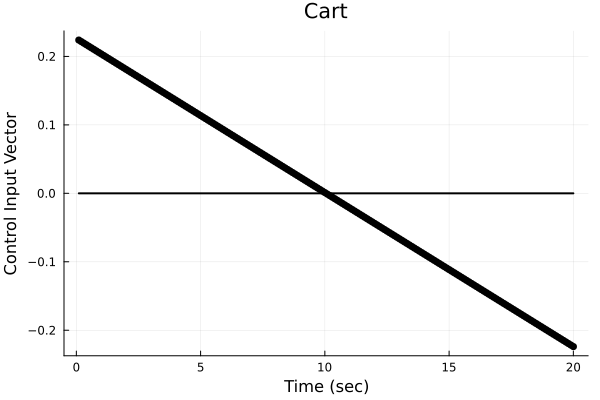

In [5]:
titre="Cart"
t=(1:N)*dt
p1=scatter(t,uControl,legend=false, title=titre, color=:black )
xlabel!("Time (sec)");ylabel!("Control Input Vector")
plot!(t,0.0*uControl,linewidth=2, color=:black)
p1

This plot shows how the cart's speed varies as a function of the position of the cart. It's not so interesting now. You will see this curve change a lot when the cart encounters perturbations.



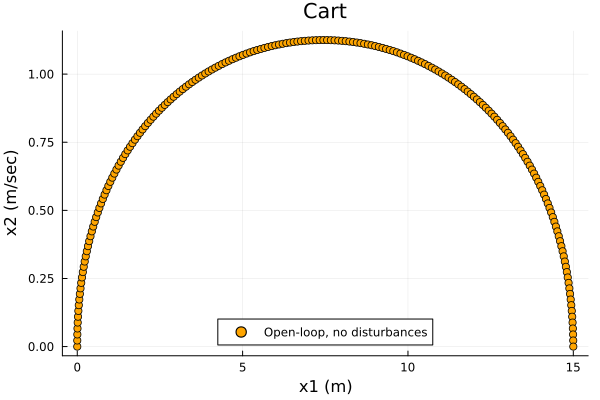

In [6]:
p2=scatter(xTrajNom[1,:], xTrajNom[2,:], title=titre, color=:orange, label = "Open-loop, no disturbances", legend=:bottom)
xlabel!("x1 (m)");ylabel!("x2 (m/sec)"); # units are meters and meters per second
p2

In [7]:
@show norm(uControl)^2
println("\n We reached our goal.")
@show norm(xGoal-xTrajNom[:,end])

norm(uControl) ^ 2 = 3.3750843771094234

 We reached our goal.
norm(xGoal - xTrajNom[:, end]) = 7.108476022178978e-15


7.108476022178978e-15

What happened? We computed an input sequence of minimum norm squared that drives the cart from Point A to Point B. We started at zero velocity, we ended with zero velocity, and we reached a peak velocity of roughly 1 m/sec at the midpoint of our trip.



We reached our goal with infinitesimal error. Our energy cost was, u^\top u = norm(u)^2 = 3.38.  
  
When one computes an input sequence and does not update it as a function of the state trajectory of a model, it is called open-loop control. When the world is nice, open-loop control works remarkably well as we just saw. We will now use the same open-loop input sequence and see how it works when the world is less benign!



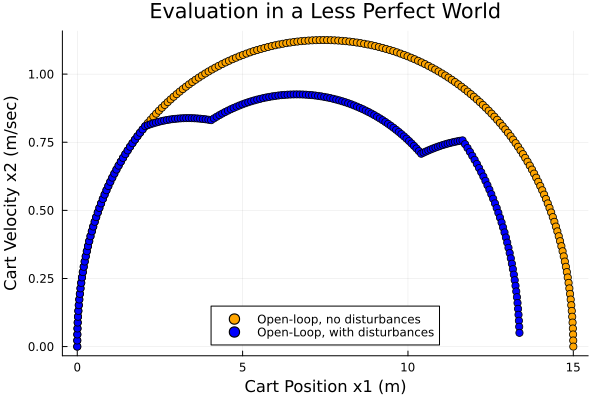

In [8]:
xTrajDist = simModelDisturbedOpenLoop(A,B,x0,uControl)

titre="Evaluation in a Less Perfect World"
p3=scatter(xTrajNom[1,:], xTrajNom[2,:], title=titre, color=:orange, label = "Open-loop, no disturbances", legend=:bottom)
scatter!(xTrajDist[1,:], xTrajDist[2,:], title=titre, color=:blue, label = "Open-Loop, with disturbances", legend=:bottom)
xlabel!("Cart Position x1 (m)");ylabel!("Cart Velocity x2 (m/sec)"); # units are meters and meters per second
p3

The blue curve does not terminate at our goal; we failed to reach it by 1.6 meters.



In [10]:
println("Error of the orange curve")
@show norm(xGoal-xTrajNom[:,end])

println("\n That did not work out so well. Look how badly we missed Point B!")
println("Error of the blue curve")
@show norm(xGoal-xTrajDist[:,end])

Error of the orange curve
norm(xGoal - xTrajNom[:, end]) = 7.108476022178978e-15

 That did not work out so well. Look how badly we missed Point B!
Error of the blue curve
norm(xGoal - xTrajDist[:, end]) = 1.6292525713033026


1.6292525713033026

┌ Info: Saved animation to d:\CODING\Julia\simpleCartDist.gif
└ @ Plots C:\Users\user\.julia\packages\Plots\kLeqV\src\animation.jl:156


Plots.AnimatedGif("d:\\CODING\\Julia\\simpleCartDist.gif")
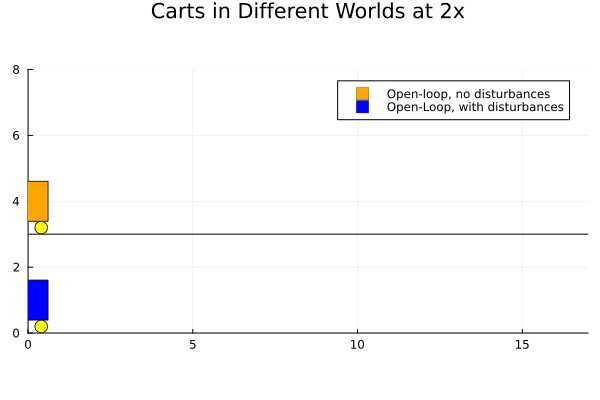

In [11]:
# Animations of the cart

plot()
anim = @animate for i = 1:size(xTrajNom,2)
    scatter([xTrajNom[1,i]], [4.0], ylim = (0,8), xlim = (0,17), markershape = :rect, markersize = 20, color=:orange,label = "Open-loop, no disturbances", aspect_ratio = :equal )
    scatter!([xTrajDist[1,i]], [1.0], markershape = :rect, markersize = 20, color=:blue, label = "Open-Loop, with disturbances" ,aspect_ratio = :equal)
    scatter!([xTrajNom[1,i]+0.4 xTrajNom[1,i]-0.4 xTrajDist[1,i]+0.4 xTrajDist[1,i]-0.4], [3.2 3.2 0.2 .2], markershape = :circle, markersize = 7, color = :yellow, label = "")
    plot!([0;25],[3.0;3.0], color = :black, label = "", title = "Carts in Different Worlds at 2x")
end

#gif(anim, "simple_cart_dist.gif", fps = 20)
gif(anim, "simpleCartDist.gif", fps = 20)

The above is the equivalent of driving blindfolded, so it's not surprising that the outcome is less than desirable. When we drive a car, we observe our progress and adjust the gas pedal and brake to keep us on track to our goal. When a system does that by itself (that is, autonomously), it is using **feedback control**.



### Cart Task 1a



If we want our cart to respond correctly so that it achieves its goal in the face of disturbances, we can’t keep applying our original control sequence. Instead, we need to re-compute the applied force at time, t\_k = kdt, as a function of our position and velocity at time k, and how we are doing with respect to our goal (position and time). That is, we want `uk` to be a function of `xk`, our goal (`xGoal`), and how much time we have left to achieve our goal, \Delta T = (N-k)dt.



Adjusting the applied force as a function of your current state measurements and goal is called feedback control or **closed-loop control**. When you compute a value ahead of time and never update it on the basis of your progress (or lack thereof) to a goal, it is called **open-loop control**.



When we recompute the input on the basis of optimization and a model of our system (model of our cart), the resulting form of feedback is called **Model Predictive Control** (MPC).



We now show you how much better we can drive the cart with MPC.



Orange: Open-Loop no disturbances
We achieve our goal perfectly using open-loop control when the world is benign and does not fight against us
norm(xGoal - xTrajNom[:, end]) = 7.108476022178978e-15

 Blue: Open-Loop with disturbances
We fail to achieve our goal when using open-loop control in the real world
norm(xGoal - xTrajDist[:, end]) = 1.6292525713033026

 Red: Feedback Control / Closed-Loop with MPC battling the disturbances
Feedback control allows us to more nearly achieve our goal in the real world
norm(xGoal - xTrajMPC[:, end]) = 0.00019220126496422046
The error is a small fraction of a millimeter.

 
 This was our consumed energy in a perfectly nice world
norm(uControl) ^ 2 = 3.3750843771094234

 This is our consumed energy in an imperfect world
norm(uTrajMPC) ^ 2 = 4.441032356751914

 Typically, there is a trade off between control effort and energy vs how accurately we achieve our objectives.

 Here, we are vastly closer to our goal with a modest increase in control effort.

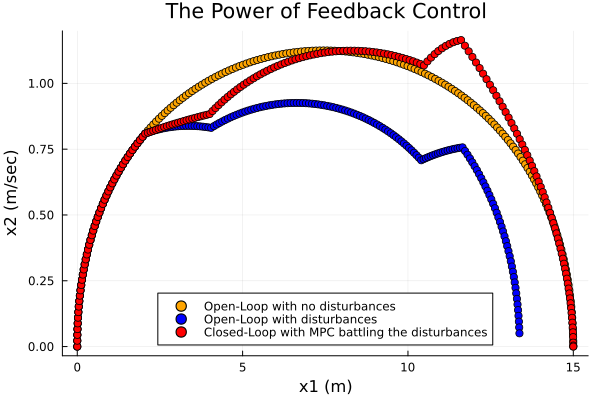

In [9]:
## TRUE OR FALSE QUESTIONS COME FROM HERE! ##

function myCartMPC(A,B,xk,k,N,xGoal)
    # xk is the current position and velocity of the cart
    # k is the time index. Hence, tk = k dt
    # N is the total amount of time we were given to reach xGoal
    # Hence, N-k is the time left
    (nr,nc) = size(A)
    nControlHoriz=max(N-k,3)  # Receeding Horizon, MPC
    S=A^nControlHoriz
    M=Array{Float64,2}(undef,nr,0)
    for i=1:nControlHoriz
        M=[A*M B]
    end
    uControl=minNormUnderdetermined(M,xGoal-S*xk)
    uk=uControl[1]
    return uk
end


function simCartMPC(x0,dt,N,xGoal)
    (A,B) = cartModel()
    (rA,cA) = size(A)
    N=1+N # because x0 is included
    xTraj = Array{Float64,2}(undef,rA,0)
    uTraj = Array{Float64,2}(undef,1,0)
    xTraj=[xTraj x0]
    for k = 1:N
        xk=xTraj[:,k]
        uk=myCartMPC(A,B,xk,k,N,xGoal)
        uTraj=[uTraj uk]
        xkp1 = xkPlus1Disturbed(A,B,xk,uk,dt)
        xTraj = [xTraj xkp1]          
    end
    return xTraj, uTraj
end

# Call simCartMPC
(xTrajMPC, uTrajMPC) = simCartMPC(x0,dt,N,xGoal)

#Analyze Results
println("Orange: Open-Loop no disturbances")
println("We achieve our goal perfectly using open-loop control when the world is benign and does not fight against us")
@show norm(xGoal-xTrajNom[:,end])

println("\n Blue: Open-Loop with disturbances")
println("We fail to achieve our goal when using open-loop control in the real world")
@show norm(xGoal-xTrajDist[:,end])

println("\n Red: Feedback Control / Closed-Loop with MPC battling the disturbances")
println("Feedback control allows us to more nearly achieve our goal in the real world")
@show norm(xGoal-xTrajMPC[:,end])
println("The error is a small fraction of a millimeter.")

println("\n \n This was our consumed energy in a perfectly nice world")
@show norm(uControl)^2
println("\n This is our consumed energy in an imperfect world")
@show norm(uTrajMPC)^2
println("\n Typically, there is a trade off between control effort and energy vs how accurately we achieve our objectives.")
println("\n Here, we are vastly closer to our goal with a modest increase in control effort. That is an acceptable tradeoff.")

#Graph Results
titre="The Power of Feedback Control"
p4=scatter(xTrajNom[1,:], xTrajNom[2,:], title=titre, color=:orange, label = "Open-Loop with no disturbances", legend=:bottom)

scatter!(xTrajDist[1,:], xTrajDist[2,:], title=titre, color=:blue, label = "Open-Loop with disturbances", legend=:bottom)

scatter!(xTrajMPC[1,:], xTrajMPC[2,:], title=titre, color=:red, label = "Closed-Loop with MPC battling the disturbances", legend=:bottom )

# units are meters and meters per second
xlabel!("x1 (m)");ylabel!("x2 (m/sec)")

Plots.AnimatedGif("d:\\CODING\\Julia\\Project\\simpleCartMPC.gif")
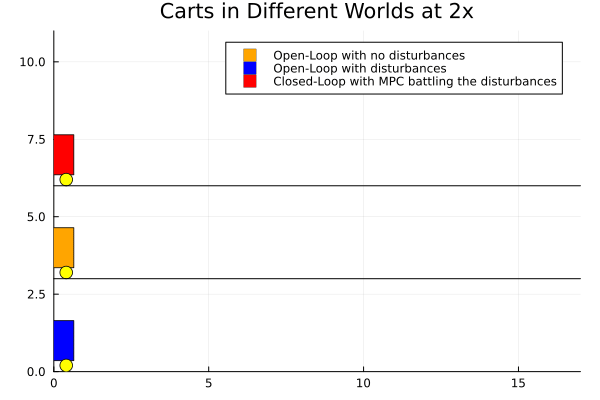

┌ Info: Saved animation to d:\CODING\Julia\Project\simpleCartMPC.gif
└ @ Plots C:\Users\user\.julia\packages\Plots\kLeqV\src\animation.jl:156


In [10]:
plot()
anim = @animate for i = 1:size(xTrajNom,2)
    scatter([xTrajNom[1,i]], [4.0], ylim = (0,11), xlim = (0,17), markershape = :rect, markersize = 20, color=:orange,label = "Open-Loop with no disturbances", aspect_ratio = :equal )
    scatter!([xTrajDist[1,i]], [1.0], markershape = :rect, markersize = 20, color=:blue, label = "Open-Loop with disturbances" ,aspect_ratio = :equal)
    scatter!([xTrajMPC[1,i]], [7.0], markershape = :rect, markersize = 20, color=:red, label = "Closed-Loop with MPC battling the disturbances" ,aspect_ratio = :equal)
    scatter!([xTrajNom[1,i]+0.4 xTrajNom[1,i]-0.4 xTrajDist[1,i]+0.4 xTrajDist[1,i]-0.4], [3.2 3.2 0.2 .2], markershape = :circle, markersize = 7, color = :yellow, label = "")
    scatter!([xTrajMPC[1,i]+0.4 xTrajMPC[1,i]-0.4], [6.2 6.2], markershape = :circle, markersize = 7, color = :yellow, label = "")
    plot!([0 0;25 25],[3.0 6.0;3.0 6.0], color = :black, label = "", title = "Carts in Different Worlds at 2x")
end
#gif(anim, "simple_cart_MPC.gif", fps = 20)
gif(anim, "simpleCartMPC.gif", fps = 20)

Answer the true or false questions based on the code above. **Please do not select an answer until you are sure. It will be locked in once you select.**



In the function `myCartMPC`,



uk = \underset{u \in \mathbb{R}^k, Mu = y}{{\rm arg~~ min}~~~ u^\top u }



where M=\left[\begin{array}{ccccc} A^{k-1}\cdot B & A^{k-2}\cdot B & \cdots & A\cdot B & B \end{array}\right] and y=xGoal-A^k ~xk



True/False quiz: The above statement is...

Answers:
 - True
- False



In the function `myCartMPC`, uk = u\_{seq}[1], where



u\_{seq} = \underset{u \in \mathbb{R}^k, Mu = y}{{\rm arg~~ min}~~~ u^\top u }



and where M=\left[\begin{array}{ccccc} A^{n-1}\cdot B & A^{n-2}\cdot B & \cdots & A\cdot B & B \end{array}\right], y=xGoal-A^{n} xk, and n=nControlHoriz.



True/False quiz: The above statement is...

Answers:
 - True
- False



In the function `myCartMPC`, uk = u\_{seq}[1], where



u\_{seq} = \underset{u \in \mathbb{R}^k, Mu = y}{{\rm arg~~ min}~~~ u^\top u }



and where M=\left[\begin{array}{ccccc} A^{k-1}\cdot B & A^{k-2}\cdot B & \cdots & A\cdot B & B \end{array}\right], and y=xGoal-A^{n} xk.



True/False quiz: The above statement is...

Answers:
 - True
- False



The function `simCartMPC` computes x\_k and u\_k for 0 \le k \le N. That is,



\begin{aligned} xTraj & = \left[\begin{array}{ccccc} x\_{0} & x\_{1}& \cdots & x\_{N-1} & x\_{N} \end{array} \right] \end{aligned}



where



x\_k=\begin{bmatrix} x\_{k,1} \\ x\_{k,2} \end{bmatrix} = \begin{bmatrix} \text{position at time } k \\ \text{velocity at time } k\end{bmatrix}



and



\begin{aligned} uTraj & = \left[\begin{array}{ccccc} u\_{0} & u\_{1}& \cdots & u\_{N-1} & u\_{N} \end{array} \right] \end{aligned}



True/False quiz: The above statement is...

Answers:
 - True
- False



Cart Task 2
-----------



You've seen the power of adjusting the applied force as a function of the position and velocity of the cart. In other words, you've seen firsthand the power of feedback control. We will now change the goal and you will tune up your feedback controller.



We will then evaluate it and score you on:



1) How efficiently you use energy as measured by u^\top u = \sum\_{i=1}^N (u\_i)^2



2) How closely you can follow a speed reference of **1 m/s** while your cart encounters a range of disturbances.



**Your new goal is to maintain a constant speed of 1 m/s. You do not care about position.**



### Cart Task 2a



Complete the code below for your new MPC-based controller. You will have to make decisions on the time horizon in the controller. You must set the variable `nControlHoriz` to an integer constant between 2 and 60. Additionally, you will have to set how the sequence `uControl` is computed.



You are playing a game against nature! You can adjust your controller's parameters as often as you wish!



In [11]:
# Here is the code skeleton!
function myCartSpeedMPC(A,B,xk,xGoal)
 # xk is the current position and velocity of the cart
 # xGoal is the goal, which should be 1 m/s
 (nr,nc) = size(A)

 nControlHoriz = # YOUR CODE HERE!
 
 # bounds nControlHoriz in case you did not follow instructions 
 nControlHoriz = minimum([maximum([nControlHoriz,2]),60]) 
 S=A^nControlHoriz
 M=Array{Float64,2}(undef,nr,0)
 for i=1:nControlHoriz
 M=[A\*M B]
 end
 
 #= 
 To think about: 
 
 S\*xk + M\*uControl is the value of x at the end 
 of your control horizon when the cart starts at xk 
 and the input sequence uControl is applied. 
 
 S\*xk + M\*uControl has two components: position and speed
 You only want to regulate one of them, the cart speed!!
 =#

 #YOUR CODE WILL REPLACE THE QUESTION MARKS!
 uControl=minNormUnderdetermined(??,xGoal.-??) 
 
 uk=uControl[1]
 return uk
end

Base.Meta.ParseError: ParseError:
# Error @ d:\CODING\Julia\Project\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y125sZmlsZQ==.jl:14:7
 for i=1:nControlHoriz
 M=[A\*M B]
#     ╙ ── not a unary operator

In [14]:
# YOUR ANSWER HERE
function myCartSpeedMPC(A,B,xk,xGoal)
    # xk is the current position and velocity of the cart
    # xGoal is the goal, which should be 1 m/s
    (nr,nc) = size(A)

    nControlHoriz = 10 # YOUR CODE HERE!
  
    # bounds nControlHoriz in case you did not follow instructions  
    nControlHoriz = minimum([maximum([nControlHoriz,2]),60]) 
    S=A^nControlHoriz
    M=Array{Float64,2}(undef,nr,0)
    for i=1:nControlHoriz
        M=[A*M B]
    end
    
    #= 
      To think about: 
  
      S*xk + M*uControl is the value of x at the end 
      of your control horizon when the cart starts at xk 
      and the input sequence uControl is applied. 
  
      S*xk + M*uControl has two components: position and speed
      You only want to regulate one of them, the cart speed!!
  =#

    #YOUR CODE WILL REPLACE THE QUESTION MARKS!
    C = [0 1]
    uControl=minNormUnderdetermined(C*M,xGoal.-C*S*xk)    
    
    uk=uControl[1]
    return uk
end

Random.seed!(4321);

function simCartSpeedMPCGrade(x0,dt,N,xGoal)
    # x0 is the intial condition
    # dt is 0.1
    # N is the total number of time steps
    # xGoal is here so that yu can pass it to 
    # your controller. It is probabaly equal to the scalar 1.0
    (A,B) = cartModel()
    (rA,cA) = size(A)
    xTraj = Array{Float64,2}(undef,rA,0)
    uTraj = Array{Float64,2}(undef,1,0)
    xTraj=[xTraj x0]
    t=0.0
    for k = 1:N
        xk=xTraj[:,k]
        uk=myCartSpeedMPC(A,B,xk,xGoal)
        uTraj=[uTraj uk]
        # You are free to update the function xkPlus1Disturbed if you want
        # to challenge yourself with different disturbances
        t=t+dt
        if abs(t-3.0)<1
           dk=-0.2 + 0.2*rand(1)[1]
        elseif abs(t-30)<1
            dk=0.2*rand(1)[1]
        elseif abs(t-20)<3
            dk=-0.3*rand(1)[1]
        elseif abs(t-70)<1
           dk=-0.2 + 0.2*rand(1)[1]
        else
            dk=0.0*rand(1)[1]
        end 
        #@show dk
        xkp1 = A*xk+B*uk+[0;.1*dk]
        # if you want to first test on a nominal (perfect model), then
        # uncomment the following line. 
        # xkp1 = A*xk + b*uk
        xTraj = [xTraj xkp1]          
    end
    return xTraj, uTraj
end

x0=[0;0.9]
N=1000
t=(1:N+1)*dt
xGoal=1
vRef=ones(N+1,1)
(xTrajMPC, uTrajMPC) = simCartSpeedMPCGrade(x0,dt,N,xGoal)
ScoreEnergy = norm(uTrajMPC)^2
ScoreSpeedError = norm(xTrajMPC[2,:]-vRef)

println("Your energy score is $ScoreEnergy \n")
println("Your tracking error score is $ScoreSpeedError \n")
println("To pass the autograder, you need your energy score less than 1.5 and your tracking score less than 1.85 \n")

if (ScoreEnergy<1.5)&(ScoreSpeedError<1.85); println("You are likely to pass! \n");else println("You fail. Re-tune your control horizon \n"); end

Your energy score is 1.4671633171636989 

Your tracking error score is 1.211265172108775 

To pass the autograder, you need your energy score less than 1.5 and your tracking score less than 1.85 

You are likely to pass! 



**Some extra code for testing** `myCartSpeedMPC`**:**



In [15]:
# Run a simulation

function simCartSpeedMPC(x0,dt,N,xGoal)
    # x0 is the intial condition
    # dt is 0.1
    # N is the total number of time steps
    # xGoal is here so that yu can pass it to 
    # your controller. It is probabaly equal to the scalar 1.0
    (A,B) = cartModel()
    (rA,cA) = size(A)
    xTraj = Array{Float64,2}(undef,rA,0)
    uTraj = Array{Float64,2}(undef,1,0)
    xTraj=[xTraj x0]
    for k = 1:N
        xk=xTraj[:,k]
        uk=myCartSpeedMPC(A,B,xk,xGoal)
        uTraj=[uTraj uk]
        # You are free to update the function xkPlus1Disturbed if you want
        # to challenge yourself with different disturbances
        xkp1 = xkPlus1Disturbed(A,B,xk,uk,dt)
        # if you want to first test on a nominal (perfect model), then
        # uncomment the following line. 
        # xkp1 = A*xk + b*uk
        xTraj = [xTraj xkp1]          
    end
    return xTraj, uTraj
end

#=
Below is code for testing your MPC controller. 
Keep adjusting your control horizon until you obtain

Energy Score < 0.4
Speed Tracking Error Score < 0.8

Achieving these values in the next test 
will set you up to pass the more difficult 
test for the autograder.

Intuition: 

A short control horizon will be very aggressive, 
and hence use a lot of Energy to accomplish the Speed Tracking Goal 
(yielding very good tracking). 

A long control horizon will be very gentle, 
and hence use a small amount Energy to accomplish the Speed Tracking Goal 
(yielding poor tracking). 

You need to balance these conflicting objectives.
=#

x0=[0;1]
N=200
dt=0.1
xGoal=1
(xTrajMPC, uTrajMPC) = simCartSpeedMPC(x0,dt,N,xGoal);

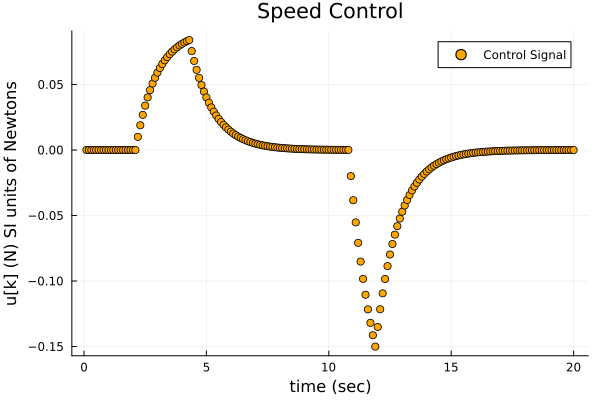

In [16]:
titre="Speed Control"
t=(1:N)*dt
p5=scatter(t, uTrajMPC', title=titre, color=:orange, label = "Control Signal")
xlabel!("time (sec)");ylabel!("u[k] (N) SI units of Newtons")

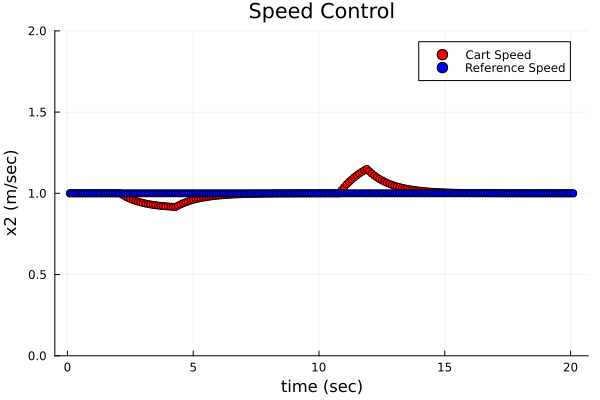

In [17]:
t=(1:N+1)*dt
p6=scatter(t, xTrajMPC[2,:], ylim=(0, 2), title=titre, color=:red, label = "Cart Speed" )
xlabel!("time (sec)");ylabel!("x2 (m/sec)");
vRef=ones(N+1,1)
scatter!(t, vRef, title=titre, color=:blue, label = "Reference Speed" )

In [18]:
ScoreEnergy = norm(uTrajMPC)^2
ScoreSpeedError = norm(xTrajMPC[2,:]-vRef)
println("Your energy score is $ScoreEnergy")
println("Your tracking accuracy score is $ScoreSpeedError")
if (ScoreEnergy<0.4)&(ScoreSpeedError<0.8); println("You passed!");else println("You fail. Re-tune your control horizon"); end

Your energy score is 0.3294651457954844
Your tracking accuracy score is 0.573990545654387
You passed!


Submit and Continue to the Project 3, Segway Task!
--------------------------------------------------

